In [4]:
!git clone https://github.com/ssingh1997/CV_Snap_Filter.git

fatal: destination path 'CV_Snap_Filter' already exists and is not an empty directory.


### Imports

In [5]:
import zipfile
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import cv2
import math
from PIL import Image
import torch
import torchvision.transforms as T

### Training and Test Data Extraction

In [6]:
data_zip = './CV_Snap_Filter/facial-keypoints-detection.zip'
with zipfile.ZipFile(data_zip, 'r') as zip_ref:
    zip_ref.extractall('.')

In [7]:
training_zip = './training.zip'
test_zip = './test.zip'

In [8]:
with zipfile.ZipFile(training_zip, 'r') as zip_ref:
    zip_ref.extractall('.')

In [9]:
with zipfile.ZipFile(test_zip, 'r') as zip_ref:
    zip_ref.extractall('.')

In [10]:
train_data = pd.read_csv('training.csv')
test_data = pd.read_csv('test.csv')
lookup_id = pd.read_csv('IdLookupTable.csv')

In [11]:
train_data.head().T

,0,1,2,3,4
left_eye_center_x,66.033564,64.332936,65.057053,65.225739,66.725301
left_eye_center_y,39.002274,34.970077,34.909642,37.261774,39.621261
right_eye_center_x,30.227008,29.949277,30.903789,32.023096,32.24481
right_eye_center_y,36.421678,33.448715,34.909642,37.261774,38.042032
left_eye_inner_corner_x,59.582075,58.85617,59.412,60.003339,58.56589
left_eye_inner_corner_y,39.647423,35.274349,36.320968,39.127179,39.621261
left_eye_outer_corner_x,73.130346,70.722723,70.984421,72.314713,72.515926
left_eye_outer_corner_y,39.969997,36.187166,36.320968,38.380967,39.884466
right_eye_inner_corner_x,36.356571,36.034723,37.678105,37.618643,36.98238
right_eye_inner_corner_y,37.389402,34.361532,36.320968,38.754115,39.094852


In [12]:
test_data.head()

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


In [13]:
lookup_id.head().T

,0,1,2,3,4
RowId,1,2,3,4,5
ImageId,1,1,1,1,1
FeatureName,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x
Location,NaN,NaN,NaN,NaN,NaN


# Data Preprocessing

In [14]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

In [15]:
#Dropping Null values
train_data.dropna(inplace=True)

In [16]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2140 entries, 0 to 2283
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          2140 non-null   float64
 1   left_eye_center_y          2140 non-null   float64
 2   right_eye_center_x         2140 non-null   float64
 3   right_eye_center_y         2140 non-null   float64
 4   left_eye_inner_corner_x    2140 non-null   float64
 5   left_eye_inner_corner_y    2140 non-null   float64
 6   left_eye_outer_corner_x    2140 non-null   float64
 7   left_eye_outer_corner_y    2140 non-null   float64
 8   right_eye_inner_corner_x   2140 non-null   float64
 9   right_eye_inner_corner_y   2140 non-null   float64
 10  right_eye_outer_corner_x   2140 non-null   float64
 11  right_eye_outer_corner_y   2140 non-null   float64
 12  left_eyebrow_inner_end_x   2140 non-null   float64
 13  left_eyebrow_inner_end_y   2140 non-null   float

### Sample Image in Training Data

In [17]:
imag = []
for i in range(0,train_data.shape[0]):
    if i in train_data.index:
      img = train_data['Image'][i].split(' ')
      img = ['0' if x == '' else x for x in img]
      imag.append(img)
    else:
      pass

In [18]:
img_arr = np.array(imag, dtype='float')
x_train = img_arr.reshape(-1, 96, 96, 1)

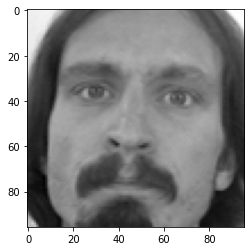

In [19]:
plt.imshow(x_train[0].reshape(96,96),cmap='gray')
plt.show()

In [20]:
train_data.T[0]['left_eye_center_x']

66.0335639098

In [21]:
train_data.head().T

,0,1,2,3,4
left_eye_center_x,66.033564,64.332936,65.057053,65.225739,66.725301
left_eye_center_y,39.002274,34.970077,34.909642,37.261774,39.621261
right_eye_center_x,30.227008,29.949277,30.903789,32.023096,32.24481
right_eye_center_y,36.421678,33.448715,34.909642,37.261774,38.042032
left_eye_inner_corner_x,59.582075,58.85617,59.412,60.003339,58.56589
left_eye_inner_corner_y,39.647423,35.274349,36.320968,39.127179,39.621261
left_eye_outer_corner_x,73.130346,70.722723,70.984421,72.314713,72.515926
left_eye_outer_corner_y,39.969997,36.187166,36.320968,38.380967,39.884466
right_eye_inner_corner_x,36.356571,36.034723,37.678105,37.618643,36.98238
right_eye_inner_corner_y,37.389402,34.361532,36.320968,38.754115,39.094852


In [22]:
train_data.T

,0,1,2,3,4,5,6,7,8,9,...,2272,2273,2274,2275,2276,2277,2278,2281,2282,2283
left_eye_center_x,66.033564,64.332936,65.057053,65.225739,66.725301,69.680748,64.131866,67.468893,65.80288,64.121231,...,66.827593,64.126581,63.738273,64.644616,64.383649,67.180378,65.72449,68.430866,64.15218,66.683755
left_eye_center_y,39.002274,34.970077,34.909642,37.261774,39.621261,39.968748,34.29004,39.413452,34.7552,36.740308,...,30.620361,33.096095,34.407682,34.280084,35.104561,35.816373,36.30102,38.651975,30.691592,34.483429
right_eye_center_x,30.227008,29.949277,30.903789,32.023096,32.24481,29.183551,29.578953,29.355961,27.47584,29.468923,...,25.111875,25.716503,26.854206,28.284307,30.424912,33.239956,25.377551,28.895857,27.000898,30.78449
right_eye_center_y,36.421678,33.448715,34.909642,37.261774,38.042032,37.563364,33.13804,39.621717,36.1856,38.390154,...,33.298484,38.118015,39.145823,38.586911,33.399298,34.921932,37.311224,37.617027,40.868082,38.578939
left_eye_inner_corner_x,59.582075,58.85617,59.412,60.003339,58.56589,62.864299,57.797154,59.554951,58.65216,58.620923,...,58.383626,57.887226,56.297606,57.75651,57.814386,59.347973,58.530612,61.65935,56.505624,59.255347
left_eye_inner_corner_y,39.647423,35.274349,36.320968,39.127179,39.621261,40.169271,35.15404,40.454773,37.32928,37.840615,...,33.172455,34.952683,36.662645,36.588318,37.715088,37.000904,37.739796,40.100902,34.126963,36.065143
left_eye_outer_corner_x,73.130346,70.722723,70.984421,72.314713,72.515926,76.898243,69.026577,75.591612,72.95296,71.272,...,77.104027,73.318216,72.467827,73.673751,72.551228,72.667896,74.44898,75.586792,73.436776,73.942694
left_eye_outer_corner_y,39.969997,36.187166,36.320968,38.380967,39.884466,41.171888,34.29004,40.038245,35.89952,37.290338,...,32.544829,32.913479,34.297713,33.584799,35.841403,37.0976,37.52551,40.219182,28.556335,34.624653
right_eye_inner_corner_x,36.356571,36.034723,37.678105,37.618643,36.98238,36.401047,34.761664,37.478214,36.3424,36.344615,...,33.555842,34.177677,35.574892,36.334975,40.193333,39.404349,33.55102,37.665118,34.746122,37.478531
right_eye_inner_corner_y,37.389402,34.361532,36.320968,38.754115,39.094852,39.367626,33.71404,40.454773,37.0432,39.490462,...,34.495763,38.483245,39.884864,39.375088,36.578245,36.589944,38.107143,39.087245,40.506939,39.398041


### Dictionary Datastructure for Landmarks

In [23]:
def get_landmarks(train_data):
  landmarks_dict = {}
  k=0
  for i in tqdm(range(train_data.shape[0])):
    if i in train_data.index:
      landmarks_dict[k] = {
          'left eye center': (train_data['left_eye_center_x'][i], train_data['left_eye_center_y'][i]),
          'right eye center': (train_data['right_eye_center_x'][i], train_data['right_eye_center_y'][i]),

          'left eye inner corner': (train_data['left_eye_inner_corner_x'][i], train_data['left_eye_inner_corner_y'][i]),
          'left eye outer corner': (train_data['left_eye_outer_corner_x'][i], train_data['left_eye_outer_corner_y'][i]),

          'right eye inner corner': (train_data['right_eye_inner_corner_x'][i], train_data['right_eye_inner_corner_y'][i]),
          'right eye outer corner': (train_data['right_eye_outer_corner_x'][i], train_data['right_eye_outer_corner_y'][i]),

          'left eyebrow inner end': (train_data['left_eyebrow_inner_end_x'][i], train_data['left_eyebrow_inner_end_y'][i]),
          'left eyebrow outer end': (train_data['left_eyebrow_outer_end_x'][i], train_data['left_eyebrow_outer_end_y'][i]),

          'right eyebrow inner end': (train_data['right_eyebrow_inner_end_x'][i], train_data['right_eyebrow_inner_end_y'][i]),
          'right eyebrow outer end': (train_data['right_eyebrow_outer_end_x'][i], train_data['right_eyebrow_outer_end_y'][i]),

          'nose tip': (train_data['nose_tip_x'][i], train_data['nose_tip_y'][i]),

          'mouth left corner': (train_data['mouth_left_corner_x'][i], train_data['mouth_left_corner_y'][i]),
          'mouth right corner': (train_data['mouth_right_corner_x'][i], train_data['mouth_right_corner_y'][i]),

          'mouth center top lip': (train_data['mouth_center_top_lip_x'][i], train_data['mouth_center_top_lip_y'][i]),
          'mouth center bottom lip': (train_data['mouth_center_bottom_lip_x'][i], train_data['mouth_center_bottom_lip_y'][i]),
      }
      k+=1
    else:
      pass

  return landmarks_dict

In [24]:
landmarks_dict = get_landmarks(train_data)

100%|████████████████████████████████████| 2140/2140 [00:00<00:00, 10396.67it/s]


### Sample Image with Landmarks Plotted

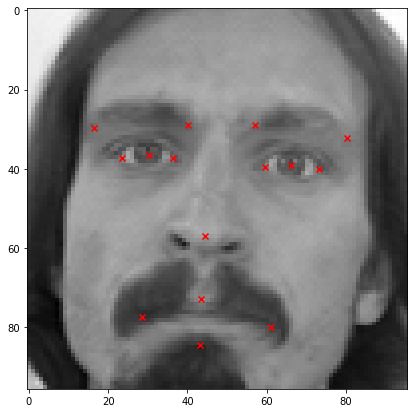

In [25]:
plt.figure(figsize=(7, 7))
plt.imshow(x_train[0].reshape(96,96),cmap='gray')

xs = []
ys = []
for value in landmarks_dict[0].values():
  xs.append(value[0])
  ys.append(value[1])
plt.scatter(xs, ys, marker='x', color='red')
plt.show()

In [26]:
training = train_data.drop('Image',axis = 1)

y_train = []
for i in range(0,len(training)):
    if i in train_data.index:
        y = training.iloc[i,:]

        y_train.append(y)
y_train = np.array(y_train,dtype = 'float')

# Data Augmentation

In [27]:
#Rotation Helper for manual landmarking on face
def rotation_helper(angle):
    if(angle>=0 and angle <=90):
        x=angle*(96/90)
        if(angle>=0 and angle<=45):
            y=-1*angle*(24/45)
        else:
            y=(angle-45)*(24/45)-24
    elif(angle>=91 and angle<=180):
        y=(angle-90)*(96/90)
        if(angle>=91 and angle<=135):
            x=(angle-90)*(24/45)+96
        else:
            x=-1*(angle-135)*(24/45)+120
    elif(angle>=181 and angle<=270):
        x=-1*(angle-180)*(96/90)+96
        if(angle>=181 and angle<=225):
            y=(angle-180)*(24/45)+96
        else:
            y=-1*(angle-225)*(24/45)+120
    else:
        y=-1*(angle-270)*(96/90)+96
        if(angle>=271 and angle<=315):
            x=-1*(angle-270)*(24/45)
        else:
            x=(angle-315)*(24/45)-24
    return x,y

### Random Rotation and Scaling Transforms for augmenting images
### Transformed Landmarks on the images Manually  

In [28]:
def affine_transform(image,landmark):
    rotation=random.randint(0,360)
    translation_x=random.randint(1,5)
    translation_y=random.randint(1,5)
    scaling = 1
#     print(rotation)
#     print(translation_x)
#     print(translation_y)
#     print(scaling)
    
    new_img=T.functional.affine(image,angle=rotation,scale=scaling,shear=0,translate=[translation_x,translation_y])
    delta_x,delta_y=rotation_helper(rotation)
#     print(delta_x)
#     print(delta_y)
    new_landmark={}
    rotation=rotation*(math.pi/180)
    k=list(landmark.keys())
    j=0
    for i in list(landmark.values()):
        new_x=i[0]*math.cos(rotation)-i[1]*math.sin(rotation)+translation_x+delta_x
        new_y=i[0]*math.sin(rotation)+i[1]*math.cos(rotation)+translation_y+delta_y
        v=(new_x,new_y)
        key_dict=k[j]
        new_landmark[key_dict]=v
        j+=1
    return new_img,new_landmark

In [29]:
#Augmentation using Affine Transforms
def data_augmentation_transform_affine(images,landmarks):
    new_images=[]
    k=len(landmarks_dict)
    for i in range(images.shape[0]):
        for j in range(2):
            orig_img=Image.fromarray(images[i].reshape(96,96))
            new_img,new_landmark=affine_transform(orig_img,landmarks[i])
            new_images.append(np.array(new_img).reshape(96,96,1))
            landmarks[k]=new_landmark
            k+=1
    return new_images,landmarks

In [30]:
new_images1,new_landmarks1=data_augmentation_transform_affine(x_train,landmarks_dict)

### Brightness and Sharpness adjustment for augmenting images

In [31]:
#Augmentation using Intensity Transforms
def data_augmentation_transform_intensity(images,landmarks):
    new_images=[]
    k=len(landmarks_dict)
    for i in range(images.shape[0]):
        orig_img=Image.fromarray(images[i].reshape(96,96))
        orig_img=orig_img.convert('RGB')
        #new_img1=T.functional.autocontrast(orig_img)
        jitter = T.ColorJitter(brightness=0.8)
        new_img1=jitter(orig_img)
        new_img2=T.functional.adjust_sharpness(orig_img,2)
        new_img1=new_img1.convert('L')
        new_img2=new_img2.convert('L')
        new_images.append(np.array(new_img1).reshape(96,96,1))
        landmarks[k]=landmarks[i]
        k+=1
        new_images.append(np.array(new_img2).reshape(96,96,1))
        landmarks[k]=landmarks[i]
        k+=1
    return new_images,landmarks

In [32]:
new_images2,new_landmarks2=data_augmentation_brightness(x_train,landmarks_dict)

In [33]:
new_images1=np.array(new_images1)
x_train=np.concatenate((x_train,new_images1))
new_images2=np.array(new_images2)
x_train=np.concatenate((x_train,new_images2))

### Training Data 5x after Augmentation

In [34]:
#New training data shape after augmentation
x_train.shape

(10130, 96, 96, 1)

In [35]:
#New landmarks after augmentation
len(landmarks_dict)

10130

15


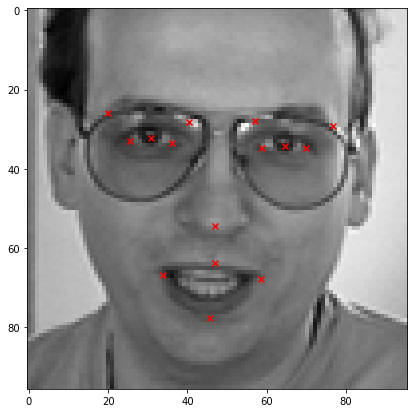

In [36]:
#Original Image in the intial training data
plt.figure(figsize=(7, 7))
plt.imshow(x_train[36].reshape(96,96),cmap='gray')

xs = []
ys = []
for value in landmarks_dict[36].values():
    xs.append(value[0])
    ys.append(value[1])
print(len(xs))
plt.scatter(xs, ys, marker='x', color='red')
plt.show()

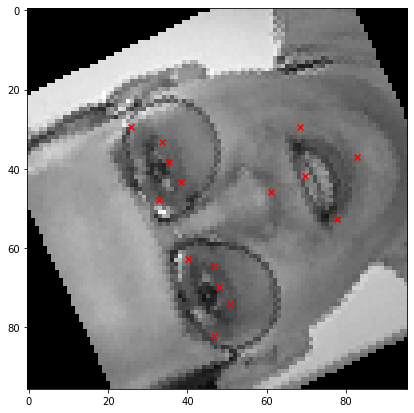

In [37]:
#Transformed image from the original image with landmarks transformed along with the image
#Test for new affine transformed images
#Checking whether landmarks are properly applied for the transformed images
plt.figure(figsize=(7, 7))
plt.imshow(x_train[2099].reshape(96,96),cmap='gray')

xs = []
ys = []
for value in landmarks_dict[2099].values():
    xs.append(value[0])
    ys.append(value[1])
plt.scatter(xs, ys, marker='x', color='red')
plt.show()

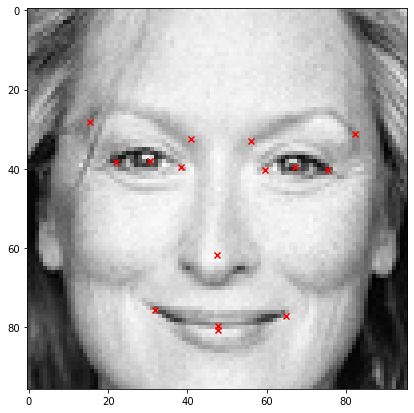

In [38]:
#Original Image in the intial training data
plt.figure(figsize=(7, 7))
plt.imshow(x_train[1990].reshape(96,96),cmap='gray')

xs = []
ys = []
for value in landmarks_dict[1990].values():
    xs.append(value[0])
    ys.append(value[1])
plt.scatter(xs, ys, marker='x', color='red')
plt.show()

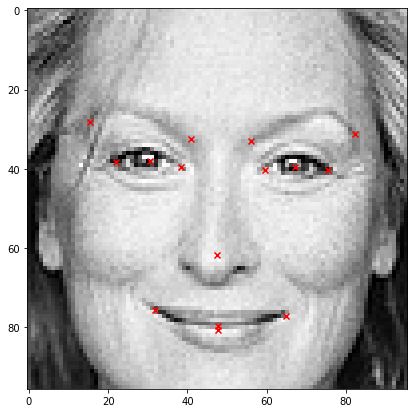

In [39]:
#Test for new sharpness and contrast adjusted images
plt.figure(figsize=(7, 7))
plt.imshow(x_train[10059].reshape(96,96), cmap = 'gray')

xs = []
ys = []
for value in landmarks_dict[10059].values():
  xs.append(value[0])
  ys.append(value[1])
plt.scatter(xs, ys, marker='x', color='red')
plt.show()

In [40]:
print(x_train[10059].reshape(96,96).astype('uint8'))
test_img = x_train[10059].reshape(96,96).astype('uint8')
test_img_rgb = cv2.cvtColor(test_img,cv2.COLOR_GRAY2RGBA)

[[110 115  94 ... 164 202 202]
 [ 99 112 144 ... 120 175 197]
 [ 95 109 115 ... 137 144 160]
 ...
 [ 75  34  20 ...  51  10  57]
 [ 83  40  20 ...  17  24  72]
 [ 76  52  30 ...  28  39  71]]


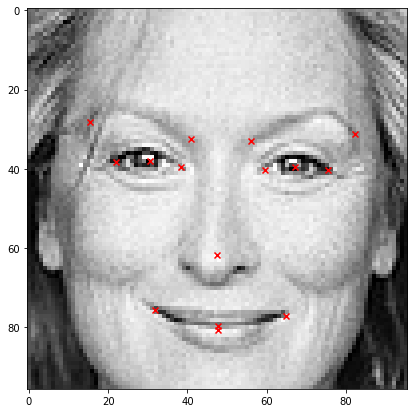

In [41]:
#Test for new sharpness and contrast adjusted images
plt.figure(figsize=(7, 7))
plt.imshow(test_img_rgb, cmap = 'gray')

xs = []
ys = []
for value in landmarks_dict[10059].values():
  xs.append(value[0])
  ys.append(value[1])
plt.scatter(xs, ys, marker='x', color='red')
plt.show()

# Affine Transformation Implementation

## Setting up Images & Landmarks

In [44]:
#for using images without scaling them down
def im_setup(img_path, width, height):
    im = cv2.imread(img_path, -1)
    (h, w) = im.shape[:2]
    im = cv2.resize(im, (width,height), interpolation = cv2.INTER_AREA)
    im_uint8 = ((im - np.min(im)) * (1/(np.max(im) - np.min(im)) * 255)).astype('uint8')
    RGB_im = cv2.cvtColor(im_uint8, cv2.COLOR_BGR2RGBA)
    return RGB_im

In [740]:
def createLandMarks(img_type, width,height):
    #landmarks, to be hard set on certain filters
    landmarks = []
    mark_vals = []
    if(img_type == 'nose'):
        #nose 
        landmarks.append((width//2,height *.4))
        
        #left lip
        landmarks.append((.25 * width,height* .7))
        
        #right lip 
        landmarks.append((width - .25 * width ,height* .7 ))
        
        mark_vals = [10,11,12]
        #upper lip
        #xs.append(width//2 )
        #ys.append(height* .7 )
    elif(img_type == 'glasses'):
        #left brow
        landmarks.append((width * .15 ,height * .25 ))
        
        #right brow
        landmarks.append((width * .85 ,height * .25 ))
        
        #nose
        landmarks.append((width * .5 ,height ))
        
        mark_vals = [7,9,10]
    elif(img_type == 'eyes'):
        #left brow
        landmarks.append((width * .05 ,height *.2 ))
        
        #outer eye left
        landmarks.append((width * .1 ,height *.63 ))
        
        #inner eye left
        landmarks.append((width * .36 ,height *.63 ))
        
        #inner eye right
        landmarks.append((width * .64 ,height *.63 ))
        
        #outer eye right 
        landmarks.append((width * .9 ,height *.63 ))
        
        #right brow
        landmarks.append((width * .95 ,height *.2 ))
    
        mark_vals = [7,3,0,1,5,9]
    elif(img_type == 'mouth'):
        
        #left lip
        landmarks.append((width * .05 ,height *.35 ))
        
        #nose
        landmarks.append((width * .5 ,height *.02 ))
        
        #lower lip
        landmarks.append((width * .5 ,height *.67 ))
        
        #right lip
        landmarks.append((width * .95 ,height *.35 ))
        
        mark_vals = [11,10,14,12]
        
    elif(img_type == 'mhat'):
        
        #left brow
        landmarks.append((width * .2 ,height *.75 ))
        
        #nose
        landmarks.append((width * .5 ,height ))
        
        #right brow
        landmarks.append((width * .8 ,height *.75))
        
        mark_vals = [7,10,9]
        
    elif(img_type == 'beard'):
        
        #left outer lip
        landmarks.append((width * .35 ,height *.44 ))
        
        #nose
        landmarks.append((width * .49 ,height *.27 ))
        
        #lower lip
        landmarks.append((width * .49 ,height *.5 ))
        
        #right outer lip
        landmarks.append((width * .65 ,height *.44))
        
        mark_vals = [11,10,14,12]
        
    elif(img_type == 'blush'):
        
        #left brow
        landmarks.append((width * .05 ,height *.0 ))
        
        #nose
        landmarks.append((width * .5 ,height *.67))
        
        #right brow
        landmarks.append((width * .95 ,height *.0))
        
        mark_vals = [7,10,9]
    
    elif(img_type == 'squid'):
        
        #left inner eye
        landmarks.append((width * .3 ,height *.4 ))
        
        #nose
        landmarks.append((width * .5 ,height *.95))
        
        #right inner eye
        landmarks.append((width * .7 ,height *.4))
        
        mark_vals = [2,13,4]
        
    elif(img_type == 'clown'):
        
        #left inner eye
        landmarks.append((width * .25 ,height *0 ))
        
        #nose
        landmarks.append((width * .55 ,height *.5))
        
        #right inner eye
        landmarks.append((width * .85 ,height * 0))
        
        mark_vals = [2,10,4]
        
        
    return landmarks,mark_vals

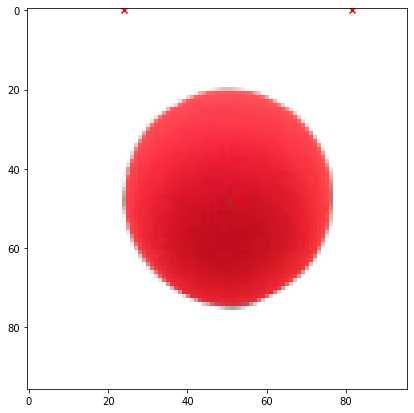

In [741]:
filter_img = im_setup('./Filter_Images/clown_nose.png', 96,96)
lm,mv = createLandMarks('clown',96,96)
xs =[]
ys = []

for val in lm:
    xs.append(val[0])
    ys.append(val[1])
    
plt.figure(figsize=(7, 7))
plt.scatter(xs, ys, marker='x', color='red')
plt.imshow(filter_img)

plt.show()

## Creating Our Own Affine Transformations Function and Trying it Out

In [742]:
#take in two sets of 3 points and figure out the affine matrix
class InvalidArraySizes(Exception):
    pass
def affine_transform_mat(sor,dest):
    #errors that could be defined 
    outMat = [[0,0,0],[0,0,0]]
    b = []
    A = []
    try:
        if(len(sor) != len(dest)): #c1 and c2 must have the same amount of points
            raise InvalidArraySizes('There must be the same amount of points in both arrays')
        if(len(sor) < 3):
            raise InvalidArraySizes('source array must have a size of 3 or more')
        if(len(dest) < 3):
            raise InvalidArraySizes('destination array must have a size of 3 or more')
    except InvalidArraySizes as e: 
        print("Error",e)
        return 0
    #setup matricies for Least Squares Error
    for i in range(0, len(sor)):
        #set up b
        b.append([dest[i][0]])
        b.append([dest[i][1]])
        
        #we can assume sor and dest have the same number of points, so set up A here as well
        #format: [xi,yi,1,0,0,0], [0,0,0,xi,yi,1]
        A.append([sor[i][0],sor[i][1],1,0,0,0])
        A.append([0,0,0,sor[i][0],sor[i][1],1])
    b_np = np.array(b)
    A_np = np.array(A)
    #Least Likely Square Equation
    #Equation: affine vars = (A^t * A)^-1 * A^t  * B
    
    A_trans = np.transpose(A_np)
    inter = np.matmul(A_trans,A_np)
    inverse = np.linalg.inv(inter)
    final = np.matmul(np.matmul(inverse,A_trans),b_np).reshape(2,3)
    
    
    
    return final



## Putting Affine Transformation & Overlay Together

In [743]:
#A function that takes in original image, the facial landmarks of the original image,
#and the type of filter to create a new image with the filters overlaying the landmarks

#FORMAT OF FUNCTION: INPUT: face_image converted to RGBA format, 
#landmarks in an array with x,y tuples ex: [(x1,y1),(x2,y2)...(xn,yn)]
#filter type is an int ranging from 0-4
def SCFilterOverlay(face_img, face_lm, filter_type):
    #variables 
    filter_lm = []
    filter_img = []
    
    face_lm_ind = []
    important_face_lm = []
    
    face_width, face_height = face_img.shape[:2]
    filter_width,filter_height = 0,0
    
    final_img = face_img.copy()
    
    
    if(filter_type == 0): #nose
        filter_img = im_setup('./Filter_Images/Luigi_Stache.png', face_width,face_height)
        filter_width,filter_height = filter_img.shape[:2]
        filter_lm,face_lm_ind = createLandMarks('nose',filter_width, filter_height)
    
    elif(filter_type == 1): #glasses
        filter_img = im_setup('./Filter_Images/HP_Glasses.png', face_width,face_height)
        filter_width,filter_height = filter_img.shape[:2]
        filter_lm,face_lm_ind = createLandMarks('glasses',filter_width, filter_height)
    
    elif(filter_type == 2): #eyes
        filter_img = im_setup('./Filter_Images/Eyes.png', face_width,face_height)
        filter_width,filter_height = filter_img.shape[:2]
        filter_lm,face_lm_ind = createLandMarks('eyes',filter_width, filter_height)
    
    elif(filter_type == 3): #mouth
        filter_img = im_setup('./Filter_Images/Binky.png', face_width,face_height)
        filter_width,filter_height = filter_img.shape[:2]
        filter_lm,face_lm_ind = createLandMarks('mouth',filter_width, filter_height)
    
    elif(filter_type == 4): #hat
        filter_img = im_setup('./Filter_Images/Mario_Hat.png', face_width,face_height)
        filter_width,filter_height = filter_img.shape[:2]
        filter_lm,face_lm_ind = createLandMarks('mhat',filter_width, filter_height)
        
    elif(filter_type == 5): #beard
        filter_img = im_setup('./Filter_Images/beard.png', face_width,face_height)
        filter_width,filter_height = filter_img.shape[:2]
        filter_lm,face_lm_ind = createLandMarks('beard',filter_width, filter_height)
        
    elif(filter_type == 6): #blush
        filter_img = im_setup('./Filter_Images/blush.png', face_width,face_height)
        filter_width,filter_height = filter_img.shape[:2]
        filter_lm,face_lm_ind = createLandMarks('blush',filter_width, filter_height)
    
    elif(filter_type == 7): #squid
        filter_img = im_setup('./Filter_Images/squidward_nose.png', face_width,face_height)
        filter_width,filter_height = filter_img.shape[:2]
        filter_lm,face_lm_ind = createLandMarks('squid',filter_width, filter_height)
        
    elif(filter_type == 8): #clown
        filter_img = im_setup('./Filter_Images/clown_nose.png', face_width,face_height)
        filter_width,filter_height = filter_img.shape[:2]
        filter_lm,face_lm_ind = createLandMarks('clown',filter_width, filter_height)
        
    #fill in important face landmarks array using array
    
    for ind in face_lm_ind:
        important_face_lm.append( (face_lm[ind][0],face_lm[ind][1]) ) 
    
    #find affine transformation of two landmarks
    trans_mat = affine_transform_mat(filter_lm,important_face_lm)
    
    #warp filter image
    new_filt_img = cv2.warpAffine(filter_img, trans_mat, (face_width,face_height))
    
    #overlay image
    # normalize alpha channels
    background = final_img[:,:,3] / 255.0
    foreground = new_filt_img[:,:,3] / 255.0
        
    # set adjusted colors
    for color in range(0, 3):
        final_img[:,:,color] = foreground * new_filt_img[:,:,color] + \
        background * final_img[:,:,color] * (1 - foreground)
    # set adjusted alpha and denormalize back to 0-255
    final_img[:,:,3] = (1 - (1 - foreground) * (1 - background)) * 255
        
    
    return final_img

## Testing out SCFilterOverlay() Function

In [754]:
lm_test_vals = []
train_ind = 20
for value in landmarks_dict[train_ind].values():
    lm_test_vals.append( (value[0],value[1]))

new_im = SCFilterOverlay(training_im[train_ind],lm_test_vals,6)
new_im2 = SCFilterOverlay(new_im,lm_test_vals,8)

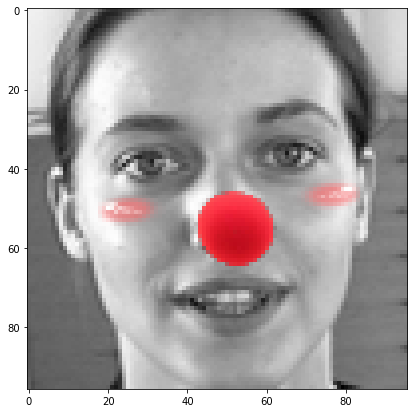

In [755]:
plt.figure(figsize=(7, 7))
plt.imshow(new_im2)